In [2]:
import ffn
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
#getting a list of S&P500 stocks from wikidpedia
table=pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')
df=table[2]
df.to_csv("S&P100-Info.csv")

In [4]:
df.head()

,Symbol,Name,Sector
0,AAPL,Apple Inc.,Information Technology
1,ABBV,AbbVie Inc.,Health Care
2,ABT,Abbott Laboratories,Health Care
3,ACN,Accenture,Information Technology
4,ADBE,Adobe Inc.,Information Technology


In [5]:
stocks = df['Symbol'].apply(lambda x: str(x))
stocks

0      AAPL
1      ABBV
2       ABT
3       ACN
4      ADBE
       ... 
96       VZ
97      WBA
98      WFC
99      WMT
100     XOM
Name: Symbol, Length: 101, dtype: object

In [6]:
sp100 = []
for item in stocks:
    sp100.append(item)

In [7]:
sp100.remove('BRK.B')

In [8]:
for i in sp100:
    try:
        data = ffn.get(i, start = "2021-01-01")
    except:
        print('There is a problem with {}'.format(i))

In [9]:
data = ffn.get(sp100, start = '2021-01-01')
#the pull from these dates only went back to Jan1,2021

In [10]:
data.head()

,aapl,abbv,abt,acn,adbe,aig,amgn,amt,amzn,avgo,...,unh,unp,ups,usb,v,vz,wba,wfc,wmt,xom
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,129.216919,104.191391,108.672203,255.586594,485.339996,36.884716,224.987106,219.600006,3186.629883,421.921936,...,348.262726,202.077393,162.769440,45.771610,217.422455,58.226662,41.009056,29.606310,145.920746,40.807007
2021-01-05,130.814514,105.268791,110.016785,257.041656,485.690002,37.500618,226.078979,220.710007,3218.510010,424.779602,...,343.579376,204.555954,160.503784,45.920479,214.177490,57.959522,40.771320,30.433691,145.143997,42.773609
2021-01-06,126.411102,104.359428,109.787712,259.852020,466.309998,39.944366,231.528458,214.889999,3138.379883,422.160065,...,357.998138,208.836197,160.026794,48.639778,212.290421,58.662003,42.623661,32.586876,146.050217,43.865074
2021-01-07,130.724655,105.476357,110.853416,262.303680,477.739990,40.619877,232.292786,217.500000,3162.159912,439.951019,...,363.737762,211.742783,157.999634,49.612381,213.478577,58.529999,44.832603,33.324543,146.040253,44.209229
2021-01-08,131.852966,106.029884,111.162170,263.260376,485.100006,40.351658,236.729797,222.199997,3182.699951,442.183594,...,362.103577,217.814774,157.393463,48.947441,215.116028,57.799999,44.783077,33.085297,146.020340,44.700878


In [11]:
#calculate the daily and annual returns
returns_daily = data.to_log_returns().dropna()
returns_annual = returns_daily.mean()*250
#return the length of the daily and annual returns dataframes
len(returns_daily), len(returns_annual)

(61, 100)

In [12]:
#get the daily and annual covariances
cov_daily = returns_daily.cov()
cov_annual = cov_daily*250

In [13]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

In [14]:
# set the number of combinations for imaginary portfolios
num_assets = len(sp100)
num_portfolios = 50000

In [15]:
#set random seed for reproduction's sake
np.random.seed(42)

In [16]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [17]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

In [18]:
# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(sp100):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

In [19]:
spdf = pd.DataFrame(portfolio)

In [20]:
# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']+ [stock+' Weight' for stock in sp100]

In [21]:
# reorder dataframe columns
spdf = spdf[column_order]

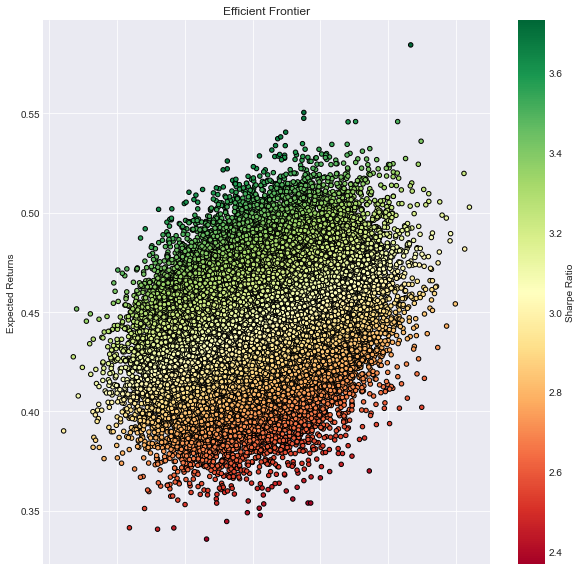

In [22]:
%matplotlib inline
plt.style.use('seaborn-dark')
spdf.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 10), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

Text(0.5, 1.0, 'Efficient Frontier')

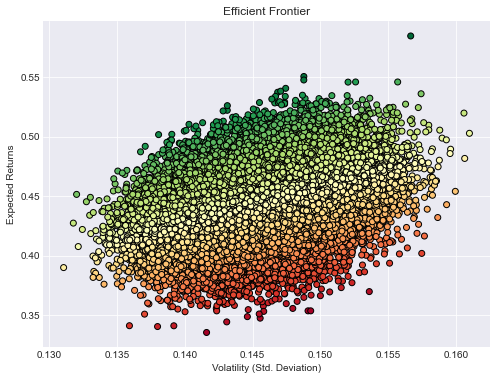

In [23]:
x1=spdf["Volatility"]
y1=spdf['Returns']
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x1,y1,
           c = spdf['Sharpe Ratio'],
          cmap='RdYlGn',
          edgecolors = 'black',
          )
ax.grid(True)
ax.set_xlabel('Volatility (Std. Deviation)')
ax.set_ylabel('Expected Returns')
ax.set_title('Efficient Frontier')

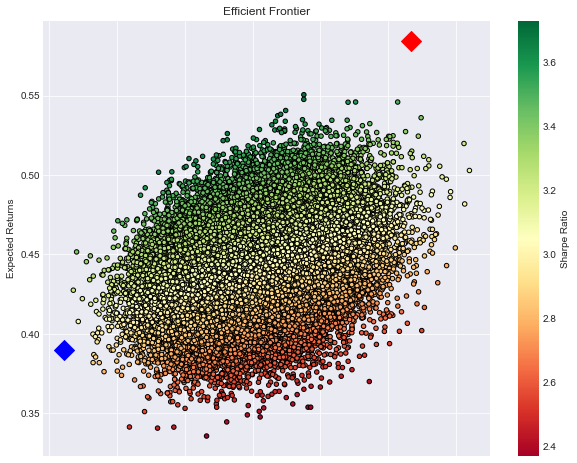

In [24]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = spdf['Volatility'].min()
max_sharpe = spdf['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = spdf.loc[spdf['Sharpe Ratio'] == max_sharpe]
min_variance_port = spdf.loc[spdf['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
spdf.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
min_variance_port.T.as_format(".2%").to_csv("min_var_sp100_2021_to_recent.csv")

In [25]:
sharpe_portfolio.T.as_format(".2%").to_csv("max_sharp_sp100_2021_to_recent.csv")